In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import astropy
from astropy.io import fits
from astropy.stats import sigma_clip
from numpy.random import randn
from numpy import mean
from numpy import ma
import warnings
warnings.filterwarnings('ignore')

In [2]:
def reject_outliers(data, m=2):
    #print(data)
    #print(' ')
    stdev = np.nanstd(data)
    mean = np.nanmean(data)
    median = np.nanmedian(data)
    Min = median - stdev * m
    Max = median + stdev * m
    #print(Min, Max)
    for p, point in enumerate(data):
        if point < Min: data[p]=np.nan
        if point > Max: data[p]=np.nan
    #print(data)
    #print(' ')
    return data

In [3]:
filters=['vv','bb','uu','w1','m2','w2']
#filters=['w2']


flatapcor=[1.086,1.086,1.10,1.11,1.12,1.15]
apcorflat=[1.086,1.086,1.10,1.11,1.12,1.15]

comps=['1','2','3','4','5','6','7','8','9','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35']
# 36-40 have been removed so they can be used for galaxy contaminated comparison stars but not aperture corrections

#comps=['1','2','3','4']
fields=['SN2005am','SN2005cf','SN2006X','SN2006aj','SN2006jc','SN2007cv','SN2007on','SN2007pk','SN2009ig','SN2010al','SN2011by','SN2011hw','SN2011iw','SN2012fr','LSQ13cuw','SN2016gxp','SN2018aoz','SN2018xx','SN2018hna','SN2019hgp','SN2019np','SN2019wep','SN2019yvq','SN2020hvf','SN2021csp','SN2021yja'] 
allfields=['SN2005am','SN2005cf','SN2006X','SN2006aj','SN2006jc','SN2007cv','SN2007on','SN2007pk','SN2009ig','SN2010al','SN2011by','SN2011hw','SN2011iw','SN2012fr','LSQ13cuw','SN2016gxp','SN2018aoz','SN2018xx','SN2018cow','SN2018hna','SN2019hgp','SN2019np','SN2019wep','SN2019yvq','SN2020hvf','SN2021csp','SN2021yja','SN2022hrs','SN2023bee','WD1026','WD1121','WD1657','GRB221009a'] 
#fields=['SN2005am'] 
#fields=['SN2006jc','SN2023bee'] 
fields=['WD1121'] 
#fields=['SN2006jc'] 
#fields=allfields
colors=['#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a']
#centroidcolors=['#73a2c6', '#f4777f', '#93003a','#00429d']
#colors=['blue','green', 'red', 'purple']
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.style.use('classic')


In [4]:

mostepochs=300
mostcomps=len(comps)

mostfilters=6
mostfields=len(fields)

cr3 =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
cr3e=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
cr5 =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
cr5e=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')

cr3_centroid =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
cr3e_centroid=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
cr5_centroid =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
cr5e_centroid=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
apcor_centroid =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
apcore_centroid=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
apcor =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
apcore=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
       
year =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
exposure=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
telapse =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
bkg=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')

year[:] = np.nan
exposure[:] = np.nan
telapse[:] = np.nan
bkg[:] = np.nan


        
cr3[:] = np.nan
cr3e[:] = np.nan
cr5[:] = np.nan
cr5e[:] = np.nan
        
cr3_centroid[:] = np.nan
cr3e_centroid[:] = np.nan
cr5_centroid[:] = np.nan
cr5e_centroid[:] = np.nan


apcor[:] = np.nan
apcore[:] = np.nan
        
apcor_centroid[:] = np.nan
apcore_centroid[:] = np.nan


frameapcor=np.empty((mostfilters, mostfields,mostepochs))
frameapcor[:] = np.nan
frameapcorscat=np.empty((mostfilters, mostfields,mostepochs))
frameapcorscat[:] = np.nan

compapcor=np.empty((mostfilters, mostfields,mostcomps))
compapcor[:] = np.nan

compapcorscat=np.empty((mostfilters, mostfields,mostcomps))
compapcorscat[:] = np.nan


for i, filter in enumerate(filters):
    print(filter)
    index=filters.index(filter)
    apcorline=[flatapcor[index],flatapcor[index]]    
    for j, field in enumerate(fields):
        #print(field)
        fieldindex=fields.index(field)
        #if index==1: 
            #ax.text(57000, 1.35-fieldindex*0.05, field, fontsize=12, color=colors[fieldindex])

        for c, comp in enumerate(comps):
            #print(" ")
            #print("comp ",int(comp))
            file        ='compdata/'+field+'_'+filter+'_senstest_comp'+comp+'_more.dat'
            filecentroid='compdata/'+field+'_'+filter+'_senstest_comp'+comp+'_centroid_more.dat'
            if os.path.exists(file):
                f = open(file, 'r')
                #print(file)
                for e, line in enumerate(f):
                    #print( x, y)
                    #print(line)
                    columns=line.split()
                    #print(field, comp)
                    #print(columns)
                    #print(columns[0],columns[1])                    
                    # columns[1] isn't parsed right but this seems to work
                    
                    #if float(columns[7])/float(columns[8]) >5:
                        
                    year[i,j,c,e]=columns[1]
                    exposure[i,j,c,e]=columns[2]
                    telapse[i,j,c,e]=columns[3]

                    cr3[i,j,c,e]=columns[4]
                    cr3e[i,j,c,e]=columns[5]
                    bkg[i,j,c,e]=columns[6]
                    cr5[i,j,c,e]=columns[7]
                    cr5e[i,j,c,e]=columns[8]
                    #apcor[i,j,c,e]=cr5[i,j,c,e]/cr3[i,j,c,e]
                    #apcore[i,j,c,e]=((cr5e[i,j,c,e]/cr5[i,j,c,e])**2.0+(cr3e[i,j,c,e]/cr3[i,j,c,e])**2.0)**0.5*apcor[i,j,c,e]
                    #print, filter, field, comp, e, apcor[i,j,c,e], apcore[i,j,c,e]
                if np.median(cr5[i,j,c,:])>150:cr5[i,j,c,:]=np.nan
                
                
                cr5[cr3<0]=np.nan
                # clean out outliers from the same epoch
                datatoclean=cr5[i,j,c,:]
                cleaneddata=reject_outliers(datatoclean, m=2)
                
                
            if os.path.exists(filecentroid):
                f = open(filecentroid, 'r')
                #print(file)
                for e, line in enumerate(f):
                    columns=line.split()

                    cr3_centroid[i,j,c,e]=columns[4]
                    cr3e_centroid[i,j,c,e]=columns[5]
                    cr5_centroid[i,j,c,e]=columns[7]
                    cr5e_centroid[i,j,c,e]=columns[8]
                    apcor_centroid[i,j,c,e]=cr5[i,j,c,e]/cr3[i,j,c,e]
                    apcore_centroid[i,j,c,e]=((cr5e[i,j,c,e]/cr5[i,j,c,e])**2.0+(cr3e[i,j,c,e]/cr3[i,j,c,e])**2.0)**0.5*apcor[i,j,c,e]
                              
                    #print(field,' ',filter,'comp ',comp,'epoch ',e,' apcor ', apcor_centroid[i,j,c,e], 'apcor error', apcore_centroid[i,j,c,e], 'centroided fraction', np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:]))
                #print("Ap 5 count rates")
                #print(cr5[i,j,c,:])
                #print("Ap Cor mean for Comp ",c+1)
                #print(c)
                #data=cr5[i,j,c,:]
                #reject_outliers(data, m=2)
                #cr5[i,j,c,:]=data
                compapcor[i,j,c]=np.nanmean(np.divide(cr5[i,j,c,:],cr3[i,j,c,:]))
                #print(compapcor[i,j,c])

                compapcorscat[i,j,c]=np.nanstd(np.divide(cr5[i,j,c,:],cr3[i,j,c,:]))
                #print("Ap Cor scat for Comp ",c+1)
                #print(compapcorscat[i,j,c])


                f.close()

        cr3=np.array(cr3, dtype=np.float32)
        cr5=np.array(cr5, dtype=np.float32)
        cr3e=np.array(cr3e, dtype=np.float32)
        cr5e=np.array(cr5e, dtype=np.float32)

        cr3[cr3/cr3e<5]=np.nan
        cr5[cr5/cr5e<5]=np.nan
        
        
        for e in range(0,len(frameapcor[i,j,:])-2):
            #print(" ")
            #print(np.divide(cr5[i,j,:,e],cr3[i,j,:,e]))
            frameapcor[i,j,e]   =np.nanmean(np.divide(cr5[i,j,:,e],cr3[i,j,:,e]))
            frameapcorscat[i,j,e]=np.nanstd(np.divide(cr5[i,j,:,e],cr3[i,j,:,e]))

frameapcor=np.array(frameapcor, dtype=np.float32)

frameapcorscat=np.array(frameapcorscat, dtype=np.float32)

compapcor=np.array(compapcor, dtype=np.float32)

compapcorscat=np.array(compapcorscat, dtype=np.float32)


apcor=cr5/cr3
apcore=((cr5e/cr5)**2.0+(cr3e/cr3)**2.0)**0.5*apcor

                    
                    
print(" ")           
                    
                    


vv
bb
uu
w1
m2
w2
 


In [5]:
# S/N cut
apcor[cr3/cr3e<5]=np.nan
apcore[cr3/cr3e<5]=np.nan
apcor[cr3<0]=np.nan
apcore[cr3<0]=np.nan

apcor_centroid[cr3/cr3e<5]=np.nan
apcore_centroid[cr3/cr3e<5]=np.nan
apcor_centroid[cr3<0]=np.nan
apcore_centroid[cr3<0]=np.nan

# high error cut

apcor[apcore>0.2]=np.nan
apcore[apcore>0.2]=np.nan

apcor_centroid[apcore>0.2]=np.nan
apcore_centroid[apcore>0.2]=np.nan



vv
bb
uu
w1
m2
w2


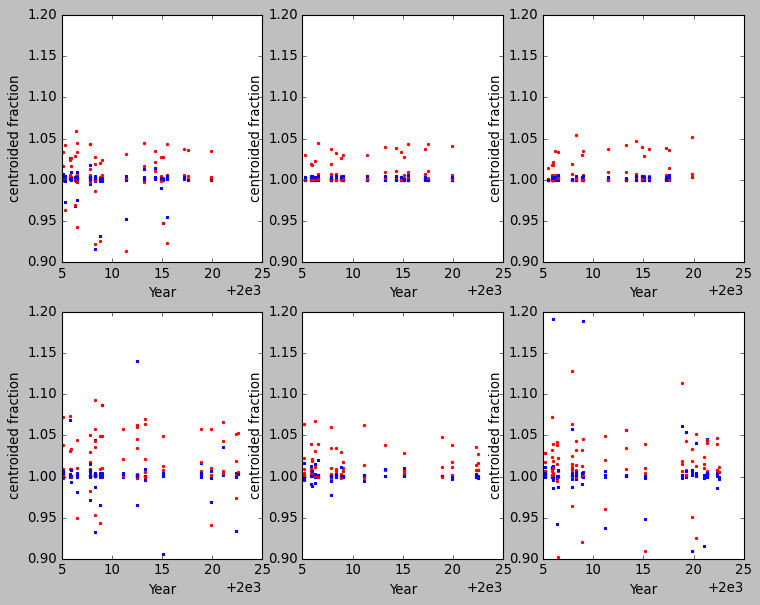

In [6]:
'''
# This shows the  difference between the photometry with and without centroiding
'''
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    print(filter)
    index=filters.index(filter)
    ax = fig.add_subplot(2,3, index+1)
    ax.set_xlabel('Year')

    ax.set_ylabel('centroided fraction')
    ax.axis([2005,2025,0.9, 1.2])
    
   

    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            #print(cr3[i,0,c,:])
            
            ax.errorbar(year[i,j,c,:], np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:]),  marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')
            ax.errorbar(year[i,j,c,:], np.divide(cr3_centroid[i,j,c,:],cr3[i,j,c,:]),  marker='o', linestyle='none', mfc='red',mec='red', ms=2, mew=1, color='red')

            #ax.errorbar(year[i,j,c,:], frameapcor[i,j,:], frameapcorscat[i,j,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

        
plt.savefig('UVOTcentroid_year.png', dpi=300, bbox_inches='tight')
plt.show()

vv
bb
uu
w1
m2
w2


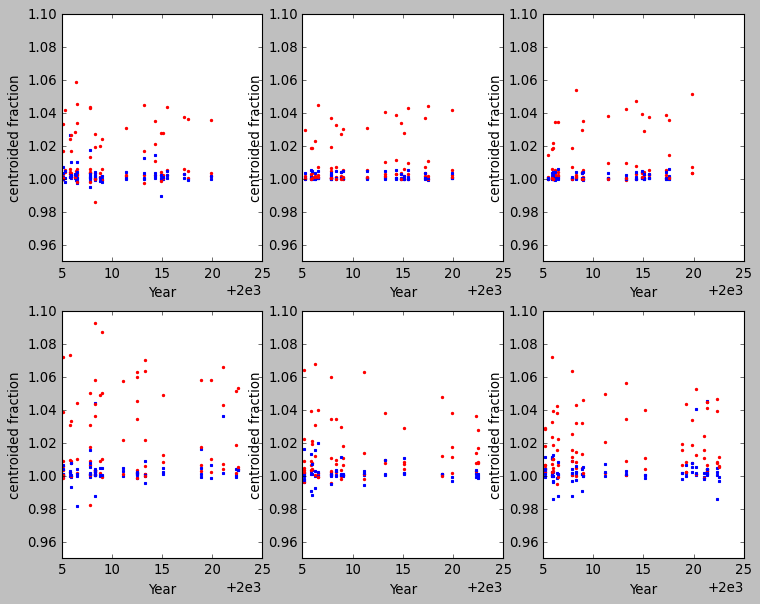

In [7]:
'''
# This shows the  difference between the photometry with and without centroiding
'''
cr5_centroid[cr5_centroid/cr5<0.98]=np.nan
cr5[cr5_centroid/cr5<0.98]=np.nan
cr3_centroid[cr3_centroid/cr3<0.98]=np.nan
cr3[cr3_centroid/cr3<0.98]=np.nan

cr5_centroid[cr5_centroid/cr5>1.05]=np.nan
cr5[cr5_centroid/cr5>1.05]=np.nan
cr3_centroid[cr5_centroid/cr5>1.05]=np.nan
cr3[cr5_centroid/cr5>1.05]=np.nan

fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    print(filter)
    index=filters.index(filter)
    ax = fig.add_subplot(2,3, index+1)
    ax.set_xlabel('Year')

    ax.set_ylabel('centroided fraction')
    ax.axis([2005,2025,0.95, 1.1])
    
   

    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            #print(cr3[i,0,c,:])
            ax.errorbar(year[i,j,c,:], np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:]),  marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')
            ax.errorbar(year[i,j,c,:], np.divide(cr3_centroid[i,j,c,:],cr3[i,j,c,:]),  marker='o', linestyle='none', mfc='red',mec='red', ms=2, mew=1, color='red')

            #ax.errorbar(year[i,j,c,:], frameapcor[i,j,:], frameapcorscat[i,j,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

        
plt.savefig('UVOTcentroid_test.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
apcor[cr3<0]=np.nan
apcore[cr3<0]=np.nan

apcor_centroid[cr3/cr3e<5]=np.nan
apcore_centroid[cr3/cr3e<5]=np.nan




In [9]:
'''
# This shows the  difference between the photometry with and without centroiding


fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    print(filter)
    index=filters.index(filter)
    ax = fig.add_subplot(2,3, index+1)
    ax.set_xlabel('Year')

    ax.set_ylabel('count rate')
    ax.axis([2005,2025,0, 10])
    
   
    j=1
    #for j, field in enumerate(fields):
    for c in range(len(comps)):   
            #print(cr3[i,0,c,:])
            ax.errorbar(year[i,j,c,:], cr3_centroid[i,j,c,:], 0.00001*cr3e_centroid[i,j,c,:],  marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')
            ax.errorbar(year[cr3_centroid>0], cr3_centroid[cr3_centroid>0], 0.00001*cr3e_centroid[cr3_centroid>0],  marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')

            
            
            #ax.errorbar(year[i,j,c,:], frameapcor[i,j,:], frameapcorscat[i,j,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

        
plt.savefig('UVOTcentroid_year.png', dpi=300, bbox_inches='tight')
plt.show()
'''

"\n# This shows the  difference between the photometry with and without centroiding\n\n\nfig = plt.figure(figsize=(11, 8.5))\n\nfieldindex=0\n\nfor i, filter in enumerate(filters):\n    print(filter)\n    index=filters.index(filter)\n    ax = fig.add_subplot(2,3, index+1)\n    ax.set_xlabel('Year')\n\n    ax.set_ylabel('count rate')\n    ax.axis([2005,2025,0, 10])\n    \n   \n    j=1\n    #for j, field in enumerate(fields):\n    for c in range(len(comps)):   \n            #print(cr3[i,0,c,:])\n            ax.errorbar(year[i,j,c,:], cr3_centroid[i,j,c,:], 0.00001*cr3e_centroid[i,j,c,:],  marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')\n            ax.errorbar(year[cr3_centroid>0], cr3_centroid[cr3_centroid>0], 0.00001*cr3e_centroid[cr3_centroid>0],  marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')\n\n            \n            \n            #ax.errorbar(year[i,j,c,:], frameapcor[i,j,:], frameapcorscat[i,j,:] ,   marker='s', l

vv
bb
uu
w1
m2
w2


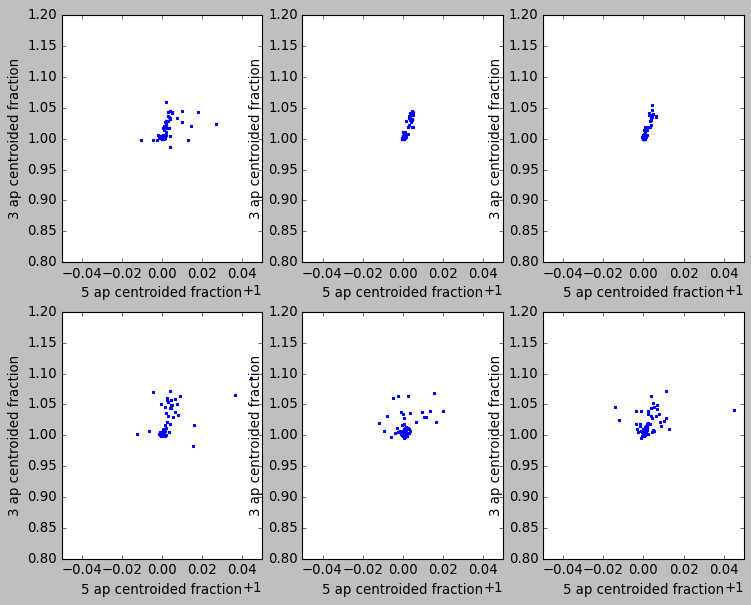

In [10]:
'''
# This shows the  difference between the photometry with and without centroiding
'''
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    print(filter)
    index=filters.index(filter)
    ax = fig.add_subplot(2,3, index+1)
    ax.set_xlabel('5 ap centroided fraction')

    ax.set_ylabel('3 ap centroided fraction')
    ax.axis([0.95,1.05,0.8, 1.2])
    
   

    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            #print(cr3[i,0,c,:])
            ax.errorbar(np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:]),np.divide(cr3_centroid[i,j,c,:],cr3[i,j,c,:]),  marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')

            #ax.errorbar(year[i,j,c,:], frameapcor[i,j,:], frameapcorscat[i,j,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

        
plt.savefig('UVOTcentroid_35.png', dpi=300, bbox_inches='tight')
plt.show()

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

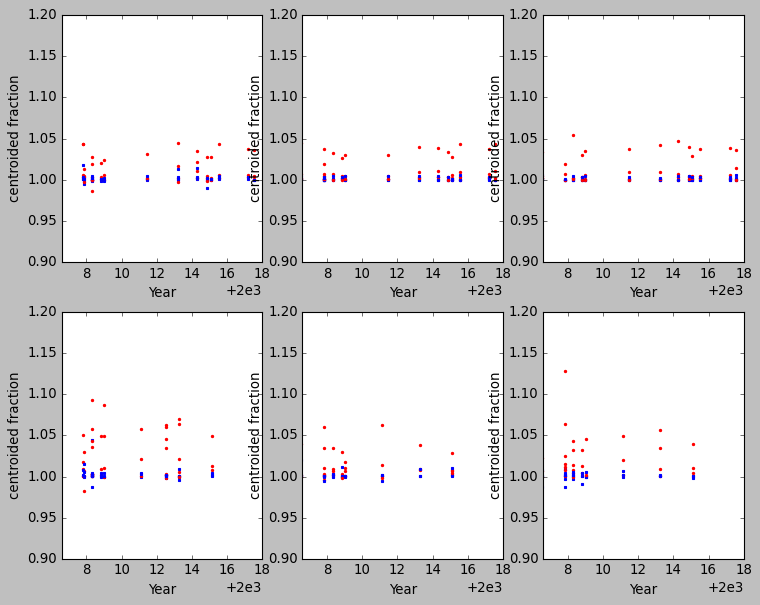

In [11]:
fig = plt.figure(figsize=(11, 8.5))

#fieldindex=0


for i, filter in enumerate(filters):

    index=filters.index(filter)
    ax = fig.add_subplot(2,3, index+1)
    ax.set_xlabel('Year')

    ax.set_ylabel('centroided fraction')
    ax.axis([2006.6,2018,0.9, 1.2])
    
   
    #j=4
    #field='SN2006jc'
    for c in range(len(comps)):   
        #print(cr3[i,0,c,:])
        ax.errorbar(year[i,j,c,:], np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:]),  marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')
        ax.errorbar(year[i,j,c,:], np.divide(cr3_centroid[i,j,c,:],cr3[i,j,c,:]),  marker='o', linestyle='none', mfc='red',mec='red', ms=2, mew=1, color='red')
        print(cr5_centroid[i,j,c,:],cr5[i,j,c,:])
        divided=np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:])
        #print(divided)
#        if any(np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:]))<1:
#        
#            the_filtered_list = list(entry for entry in divided if entry > 1)
#            print('SN2006jc', c, where(np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:]) <1))
#            print(the_filtered_list)
#        print(np.divide(cr5_centroid[i,j,c,np.isfinite(cr5_centroid[i,j,c,:])],cr5[i,j,c,np.isfinite(cr5[i,j,c,:])]),cr5_centroid[i,j,c,np.isfinite(cr5_centroid[i,j,c,:])] )
#        print( cr5_centroid[i,j,c,(cr5_centroid[i,j,c,:]<cr3_centroid[i,j,c,:] )])
                           
plt.savefig('UVOTcentroid_year.png', dpi=300, bbox_inches='tight')
plt.show()



In [12]:
apcor[cr3/cr3e<5]=np.nan
#apcor[cr5/cr5e<5]=np.nan
apcor[cr3<0]=np.nan
#apcor[cr5<0]=np.nan
       
for i, filter in enumerate(filters):
    for j, field in enumerate(fields):
        for c, comp in enumerate(comps):
            file        ='compdata/'+field+'_'+filter+'_senstest_comp'+comp+'_more.dat'
            filecentroid='compdata/'+field+'_'+filter+'_senstest_comp'+comp+'_centroid_more.dat'
            if os.path.exists(file):
                f = open(file, 'r')
                for e, line in enumerate(f):
                    print(filter, field, comp, e, apcor[i,j,c,e], apcore[i,j,c,e])
                



vv WD1121 01 0 1.0782213 0.028213734
vv WD1121 01 1 1.0967525 0.036907874
vv WD1121 01 2 1.1043069 0.019271385
vv WD1121 01 3 1.0807847 0.017289156
vv WD1121 01 4 1.0942386 0.013725993
vv WD1121 01 5 1.135103 0.020340424
vv WD1121 01 6 1.0891973 0.05509173
vv WD1121 01 7 1.1067023 0.016747955
vv WD1121 01 8 1.118127 0.077088356
vv WD1121 01 9 1.1343893 0.023398029
vv WD1121 01 10 1.1202725 0.027709916
vv WD1121 01 11 1.118795 0.019928252
vv WD1121 01 12 1.1230142 0.05813741
vv WD1121 01 13 1.0871935 0.03984966
vv WD1121 01 14 1.1167147 0.032485418
vv WD1121 01 15 1.1297413 0.024342392
vv WD1121 01 16 1.156708 0.026257725
vv WD1121 01 17 1.1526406 0.023185482
vv WD1121 01 18 1.1442839 0.028777946
vv WD1121 01 19 1.1319331 0.025840227
vv WD1121 01 20 1.1165419 0.026404167
vv WD1121 01 21 1.1622964 0.02676906
vv WD1121 01 22 1.1396941 0.040473066
vv WD1121 01 23 1.1563264 0.028267024
vv WD1121 03 0 1.1105704 0.042549036
vv WD1121 03 1 1.0844884 0.054356184
vv WD1121 03 2 1.1023281 0.02693

vv
bb
uu
w1
m2
w2


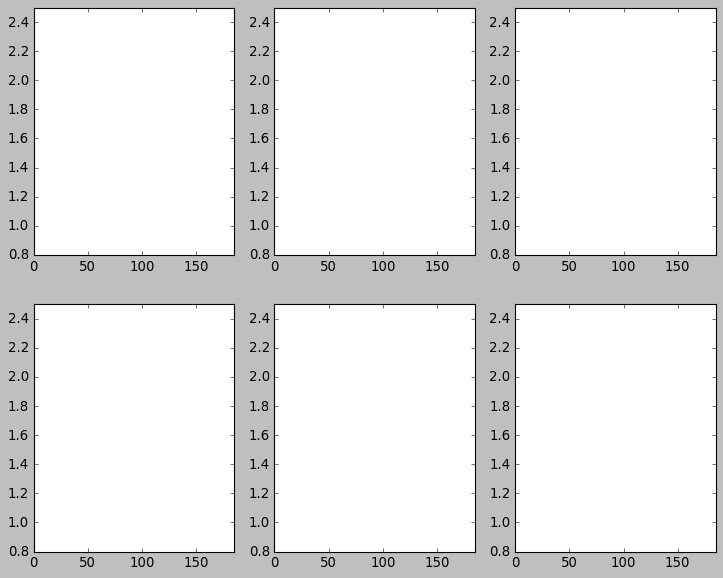

[1.0782213 1.0967525 1.1043069 1.0807847 1.0942386 1.135103  1.0891973
 1.1067023 1.118127  1.1343893 1.1202725 1.118795  1.1230142 1.0871935
 1.1167147 1.1297413 1.156708  1.1526406 1.1442839 1.1319331 1.1165419
 1.1622964 1.1396941 1.1563264 1.1105704 1.0844884 1.1023281 1.1164722
 1.0992934 1.0952663 1.1057591 1.1216756 1.2008896 1.1176803 1.1207787
 1.1177914 1.0550104 1.1597887 1.1601597 1.1210889 1.1533246 1.1547343
 1.1461586 1.171389  1.129699  1.1626009 1.1605783 1.0883886 1.0912462
 1.1031635 1.1059083 1.0889493 1.0875242 1.1389179 1.1246376 1.1091527
 1.1173263 1.1208221 1.1295774 1.1116949 1.1320635 1.1346996 1.1606983
 1.1512266 1.1325771 1.1530753 1.1581748 1.1171839 1.121839  1.1330906
 1.0894297 1.113264  1.115648  1.1547089 1.1288935 1.1346345 1.1799023
 1.1403428 1.1423182 1.1378876 1.1452984 1.1490573 1.1476771 1.1948026
 1.1775247 1.1799437 1.1797448 1.1792144 1.1959426 1.0785735 1.0955521
 1.085611  1.1015804 1.1009883 1.1200733 1.12709   1.1308635 1.1231031
 1.123

In [13]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    print(filter)
    index=filters.index(filter)
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.axis([0,185,0.8, 2.5])

    for j, field in enumerate(fields):
#        for c in range(len(comps)):   
        for c in range(7):   
  
            #print(cr3[i,0,c,:])
            ax.plot(apcor[i,j,c,:],   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

            #ax.errorbar(year[i,j,c,:], frameapcor[i,j,:], frameapcorscat[i,j,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

        
plt.show()  
print(apcor[~np.isnan(apcor)])

vv
bb
uu
w1
m2
w2


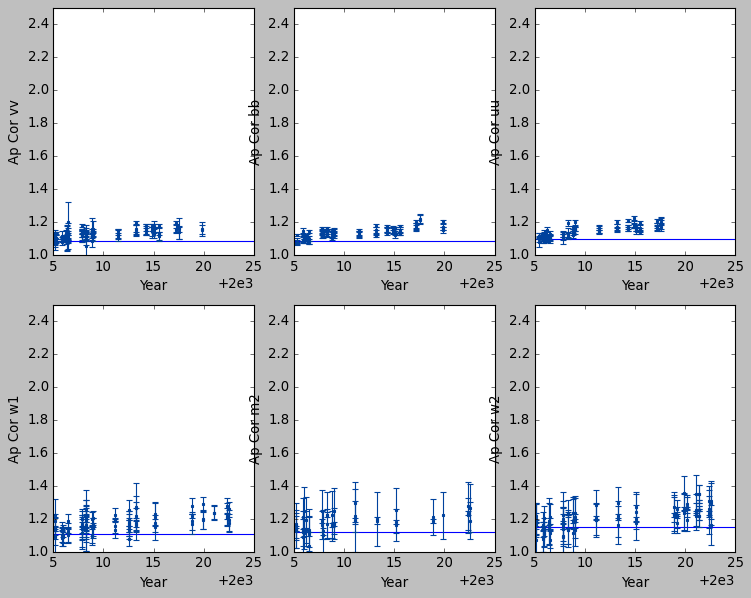

In [14]:
fig = plt.figure(figsize=(11, 8.5))

#fieldindex=0

for i, filter in enumerate(filters):
    print(filter)
    index=filters.index(filter)
    apcorline=[apcorflat[index],apcorflat[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('Year')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([2005,2025,1.0, 2.5])
    
    ax.plot([2005,2025],apcorline)
   
    

    for j, field in enumerate(fields):
        for c in range(len(comps)):   
        #for c in range(5):   
            #print(cr3[i,0,c,:])
            ax.errorbar(year[i,j,c,:], apcor[i,j,c,:], apcore[i,0,c,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex], mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

            #ax.errorbar(year[i,j,c,:], frameapcor[i,j,:], frameapcorscat[i,j,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

        
plt.savefig('UVOTapcor_year.png', dpi=300, bbox_inches='tight')
plt.show()

The above was used to find that a few bad aperture corrections are from smeared frames or stars at the edge of a frame

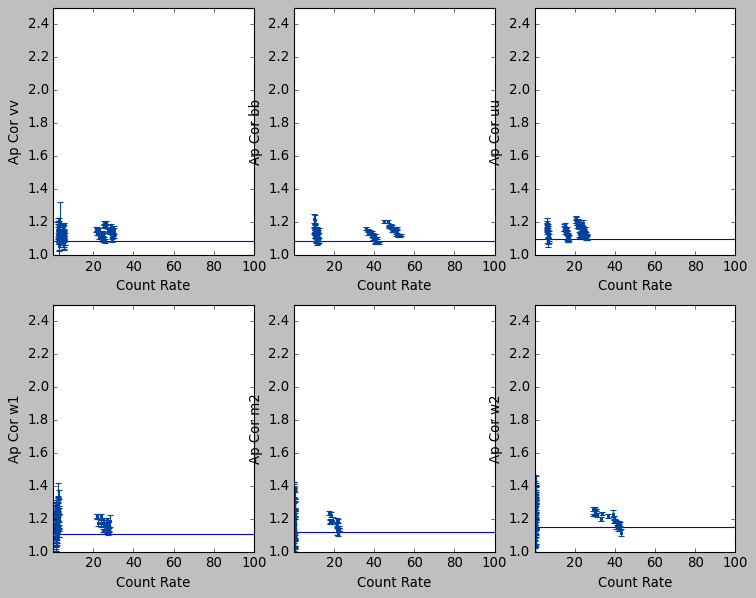

In [15]:


fig = plt.figure(figsize=(11, 8.5))





for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcorflat[index],apcorflat[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('Count Rate')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([0.01,100,1, 2.5])

    ax.plot([0.01,100],apcorline)

    for j, field in enumerate(fields):
        fieldindex=j
        for c in range(len(comps)):   
            ax.errorbar(cr5[i,j,c,:], apcor[i,j,c,:], apcore[i,0,c,:],   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

plt.savefig('UVOTapcor_cr.eps', dpi=300, bbox_inches='tight')
plt.show()

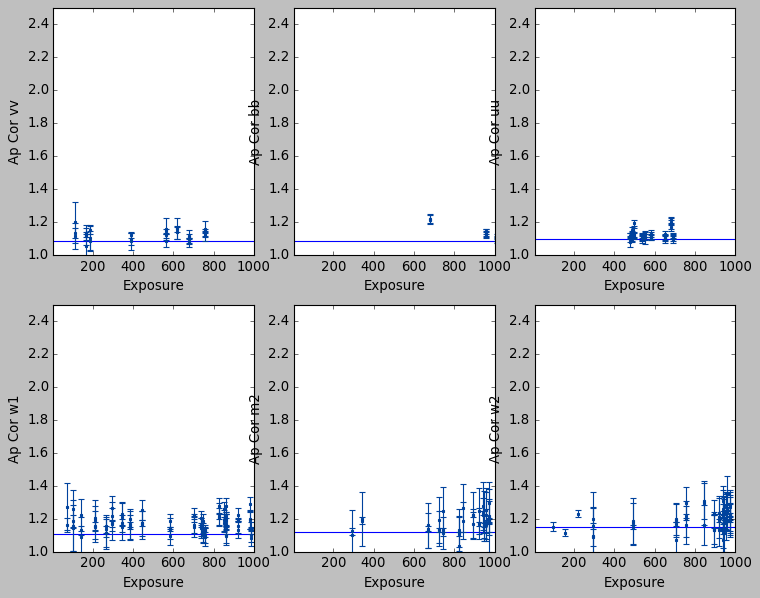

In [16]:
fig = plt.figure(figsize=(11, 8.5))

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcorflat[index],apcorflat[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('Exposure')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([5,1000,1, 2.5])
    
    ax.plot([0.01,1000],apcorline)

    for j, field in enumerate(fields):
        fieldindex=j
        for c in range(len(comps)):   
            ax.errorbar(exposure[i,j,c,:], apcor[i,j,c,:], apcore[i,0,c,:] , marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

plt.savefig('UVOTapcor_exp.png', dpi=300, bbox_inches='tight')
plt.show()

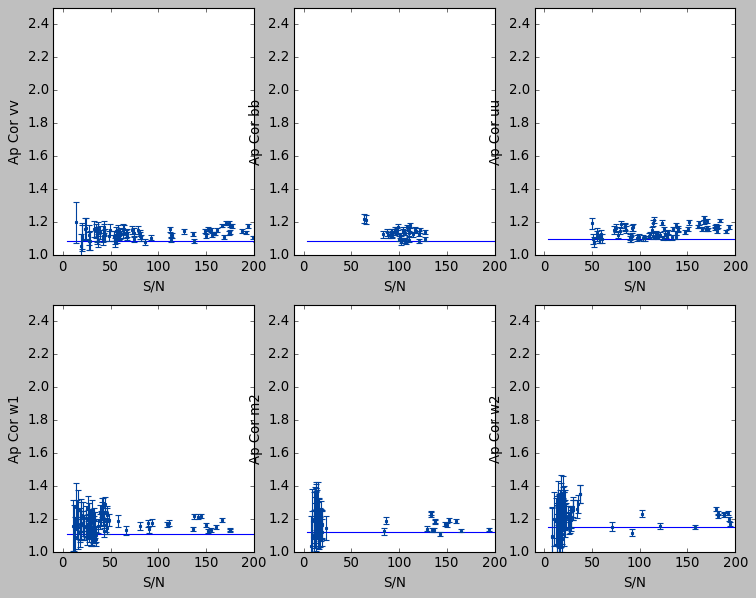

In [17]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcorflat[index],apcorflat[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('S/N')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([-10,200,1, 2.5])
    
    ax.plot([4,200],apcorline)

    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            ax.errorbar(cr5[i,j,c,:]/cr5e[i,j,c,:], apcor[i,j,c,:], apcore[i,0,c,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

plt.savefig('UVOTapcor_sn.png', dpi=300, bbox_inches='tight')
plt.show()

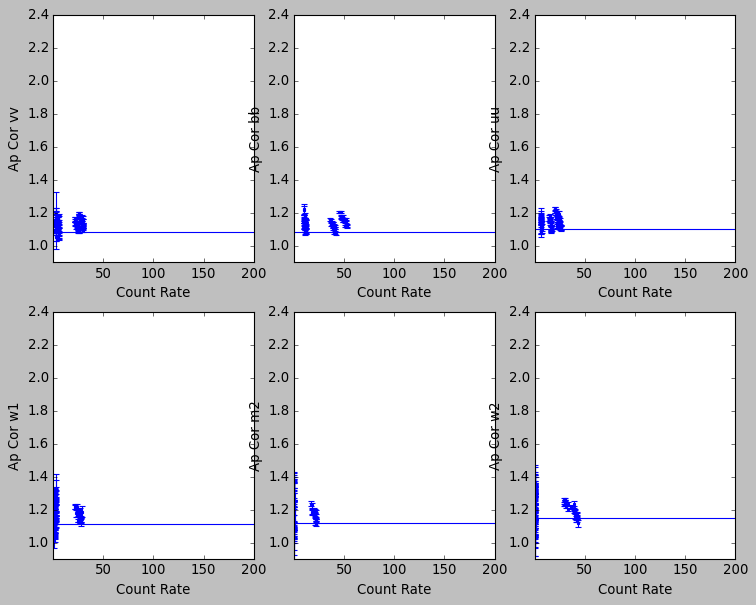

In [18]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcorflat[index],apcorflat[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('Count Rate')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([0.1,200,0.9, 2.4])
    
    ax.plot([0.1,200],apcorline)
    #ax.plt.yscale("log")
    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            if "WD" in field: ax.errorbar(cr5[i,j,c,:], apcor[i,j,c,:], apcore[i,0,c,:] ,   marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')
            if "SN" in field: ax.errorbar(cr5[i,j,c,:], apcor[i,j,c,:], apcore[i,0,c,:] ,   marker='s', linestyle='none', mfc=colors[j],mec=colors[j], ms=2, mew=1, color=colors[j])

        
plt.savefig('UVOTapcor_cr.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
import math
plotyears=np.arange(2005,2026)
plotyears
plotyearselapsed=plotyears-2005
print(plotyears)
apcorfunction=np.array(plotyears, dtype=float)


[2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021 2022 2023 2024 2025]


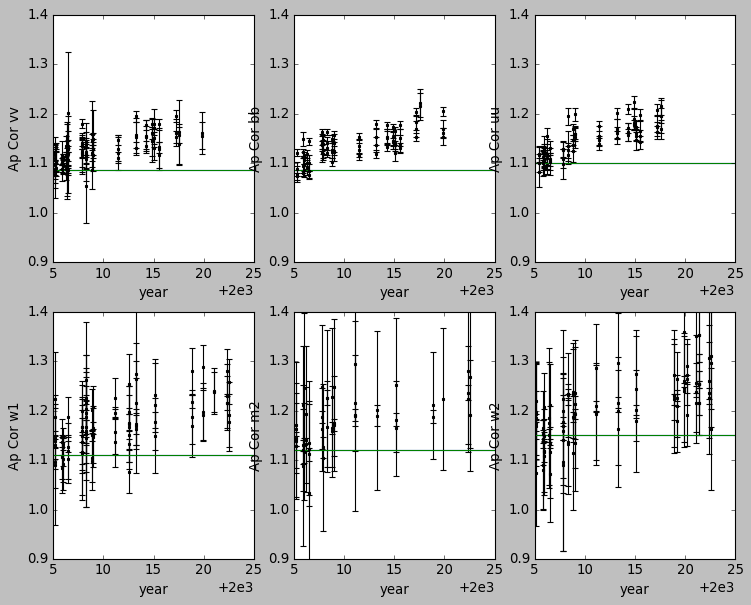

In [20]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcorflat[index],apcorflat[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('year')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([2005, 2025,0.9, 1.4])
    
    ax.plot([2005, 2025],apcorline)

    for j, field in enumerate(fields):
        for c in range(len(comps)):  
            if "WD" in field: ax.errorbar(year[i,j,c,:], apcor[i,j,c,:], apcore[i,0,c,:] ,   marker='s', linestyle='none', mfc='black',mec='black', ms=2, mew=1, color='black')
            if "SN" in field: ax.errorbar(year[i,j,c,:], apcor[i,j,c,:], apcore[i,0,c,:] ,   marker='s', linestyle='none', mfc=colors[j],mec=colors[j], ms=2, mew=1, color=colors[j])

    exp=2
    for y, plotyear in enumerate(plotyearselapsed):
        apcorfunction[y]=apcorflat[index]+(plotyear)**(1.0/exp)*(flatapcor[index]-apcorflat[index])/20.0**(1.0/exp)
    ax.plot(plotyears, apcorfunction)
   
plt.savefig('UVOTapcor_year.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
'''
indices = np.argwhere((cr5/cr3 > 1.3) & (cr5e/cr3 < 0.2))
for index in indices:
    #print(index)
    #print(index[1])
    print('edit compdata/'+fields[index[1]]+'_'+filters[index[0]]+'_senstest_comp'+comps[index[2]]+'_more.dat',  index[3]+1)
    print('ds9 -region load '+fields[index[1]]+'_comp'+comps[index[2]]+'.reg '+fields[index[1]]+'_'+filters[index[0]]+'.img\['+str(index[3]+1)+'\] &')
'''

"\nindices = np.argwhere((cr5/cr3 > 1.3) & (cr5e/cr3 < 0.2))\nfor index in indices:\n    #print(index)\n    #print(index[1])\n    print('edit compdata/'+fields[index[1]]+'_'+filters[index[0]]+'_senstest_comp'+comps[index[2]]+'_more.dat',  index[3]+1)\n    print('ds9 -region load '+fields[index[1]]+'_comp'+comps[index[2]]+'.reg '+fields[index[1]]+'_'+filters[index[0]]+'.img\\['+str(index[3]+1)+'\\] &')\n"

In [22]:
print(apcorfunction)


[1.15 1.15 1.15 1.15 1.15 1.15 1.15 1.15 1.15 1.15 1.15 1.15 1.15 1.15
 1.15 1.15 1.15 1.15 1.15 1.15 1.15]


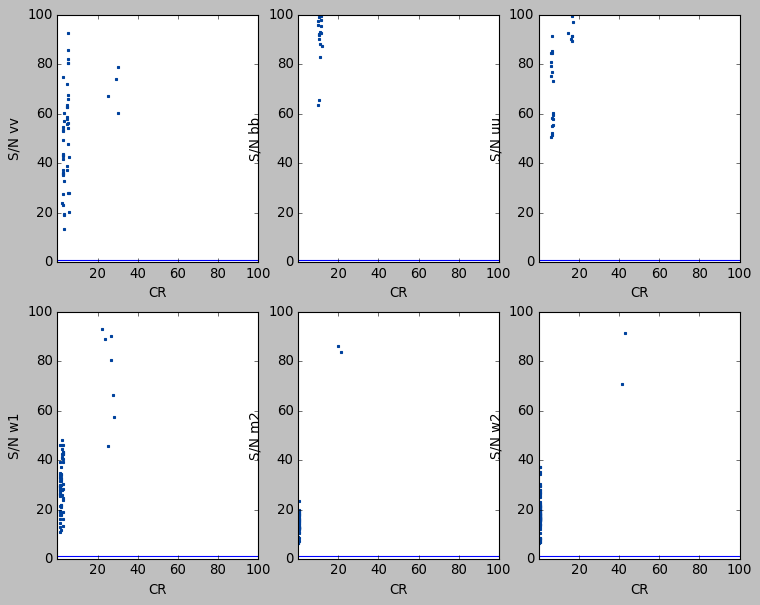

In [23]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcorflat[index],apcorflat[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('CR')

    ax.set_ylabel('S/N '+filter)
    ax.axis([0.01,100,0,100])
    
    ax.plot([0.01,100],apcorline)

    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            ax.errorbar(cr5[i,j,c,:], cr5[i,j,c,:]/cr5e[i,j,c,:],   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

plt.savefig('UVOTcr_sn.png', dpi=300, bbox_inches='tight')
plt.show()

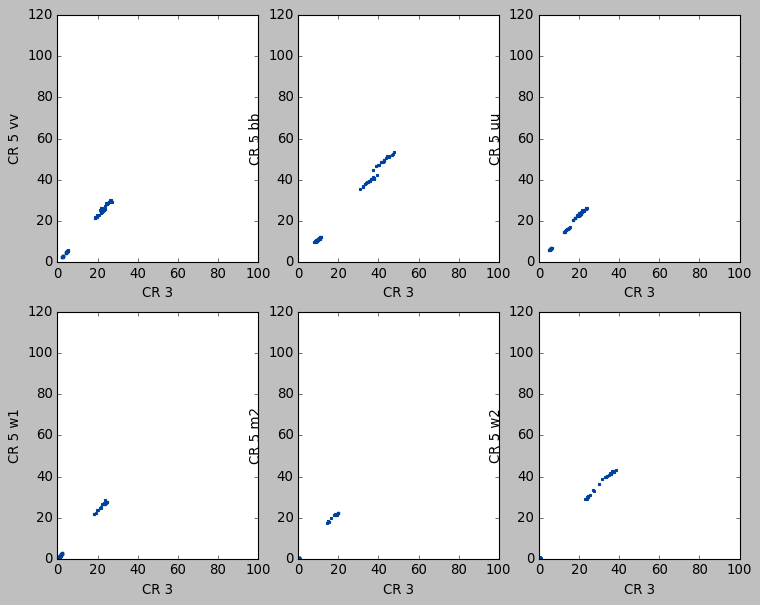

In [24]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcorflat[index],apcorflat[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('CR 3')

    ax.set_ylabel('CR 5 '+filter)
    ax.axis([0.0,100,0,120])
    
    #ax.plot([0.0,100],apcorline)

    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            ax.errorbar(cr3[i,j,c,:], cr5[i,j,c,:],   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

plt.savefig('UVOTcr_cr3vcr5.png', dpi=300, bbox_inches='tight')
plt.show()

ind2=np.argwhere((cr3 < 20) & (cr5 > 40))
#print(filter)
#print(ind2)
for n,test in enumerate(ind2[:,]):
    filterindex=(ind2[n,0])
    print(filters[filterindex],fields[ind2[n,1]], comps[ind2[n,2]], ' epoch ', ind2[n,3]  )

In [25]:
apcore[apcor>1.4]=np.nan
apcor[apcor>1.4]=np.nan
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0


flatapcor=[1.15,1.15,1.2,1.25,1.25,1.25]
apcorslope=[]


for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcorflat[index],apcorflat[index]]
    newapcorflat=[flatapcor[index],flatapcor[index]]
    newapcorslope=[apcorflat[index],flatapcor[index]]


    #f#or y, plotyear in enumerate(plotyearselapsed):
     #   apcorfunction[y]=apcorflat[index]+(plotyearselapsed)**(1/4)*flatapcor[index]/math.sqrt(20) 
    for y, plotyear in enumerate(plotyearselapsed):
        apcorfunction[y]=apcorflat[index]+(plotyearselapsed)**(1/8)*flatapcor[index]/math.sqrt(20) 
    ax.plot(plotyears, apcorfunction)

    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('year')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([2005, 2025,0.9, 1.4])
    
    ax.plot([2005, 2025],apcorline)
    ax.plot([2005, 2025],newapcorflat)
    #ax.plot([2005, 2025],newapcorslope, linewidth=2)

    
    for j, field in enumerate(fields):
        
        for c in range(len(comps)):  
            
            #if "WD" in field: ax.errorbar(year[i,j,c,:], apcor[i,j,c,:], apcore[i,j,c,:] ,   marker='s', linestyle='none', mfc='black',mec='black', ms=2, mew=1, color='black')
            #if "SN" in field: ax.errorbar(year[i,j,c,:], apcor[i,j,c,:], apcore[i,j,c,:] ,   marker='s', linestyle='none', mfc=colors[j],mec=colors[j], ms=2, mew=1, color=colors[j])
            if "WD" in field: ax.errorbar(year[i,j,c,:], apcor[i,j,c,:],    marker='s', linestyle='none', mfc='black',mec='black', ms=2, mew=1, color='black')
            if "SN" in field: ax.errorbar(year[i,j,c,:], apcor[i,j,c,:],    marker='s', linestyle='none', mfc=colors[j],mec=colors[j], ms=2, mew=1, color=colors[j])

    ax.plot(plotyears, apcorfunction)
      
plt.savefig('UVOTapcor_year.png', dpi=300, bbox_inches='tight')
plt.show()

ValueError: setting an array element with a sequence.

<Figure size 880x680 with 0 Axes>

In [ ]:
print(apcorfunction)
print(plotyears)

In [ ]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    print(filter)
    index=filters.index(filter)
    apcorline=[apcorflat[index],apcorflat[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('CR ')

    ax.set_ylabel('mean ap cor '+filter)
    ax.axis([1.0,2,1,2])
    
    #ax.plot([0.0,100],apcorline)
    print(compapcor[i,0,:])
    ax.errorbar( cr5[i,0,:,0], compapcor[i,0,:], compapcorscat[i,0,:],  marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

    

    
plt.savefig('UVOTcr_compmean.png', dpi=300, bbox_inches='tight')
plt.show()





In [ ]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcorflat[index],apcorflat[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('CR comp')

    ax.set_ylabel('CR other comp '+filter)
    ax.axis([1.0,2,1,2])
    
    #ax.plot([0.0,100],apcorline)

    ax.errorbar( cr5[i,0,:,0], frameapcor[i,0,:], frameapcorscat[i,0,:],  marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

plt.savefig('UVOTcr_framemean.png', dpi=300, bbox_inches='tight')
plt.show()


